#Load and unzip dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd /content/drive/MyDrive/Darknet; \
xz --decompress darknet-packets-pseudoanonymous.csv.xz

Because we are on colab, let's sample

In [ ]:
!tail -n 1000000 /content/drive/MyDrive/Darknet/dark.csv > /content/drive/MyDrive/Darknet/darksample.csv
!head /content/drive/MyDrive/Darknet/darksample.csv

1622298513.084904,2048,486158,26264,722278,47933,6,60,2,0
1622298513.105152,2048,242994,45785,722286,11949,6,60,2,0
1622298513.155680,2048,242994,45785,722314,11758,6,60,2,0
1622298513.181010,2048,242996,46004,722291,24680,6,60,2,0
1622298513.188235,2048,242999,46096,722294,44049,6,60,2,0
1622298513.201879,2048,242993,45826,722237,5500,6,60,2,0
1622298513.205156,2048,242999,46096,722397,44406,6,60,2,0
1622298513.215034,2048,242998,46097,722367,37944,6,60,2,0
1622298513.227097,2048,492448,36123,722417,49152,6,60,2,0
1622298513.349387,2048,242997,45700,722319,31195,6,60,2,0


In [ ]:
!pip install pandas==1.3.0

# Preprocessing

## Analysis and missng values

In [ ]:
import numpy as np
import pandas, seaborn, os, csv
import matplotlib.pyplot as plt
from statistics import mean

names=['ts','ethtype','src_ip','src_port','dst_ip','dst_port','proto','pck_len','tcp_flags','mirai']
dark = pandas.read_csv("/content/drive/MyDrive/Darknet/darksample.csv", names=names)
print(dark.shape)

(1000000, 10)


Missing value counts

In [ ]:
# types=['float64','int16','int32','int16','int32','int16','int16','int16','int8','bool']
# types=[np.float64, np.int16, np.int32, np.int16, np.int32, np.int16, np.int16, np.int16, np.int8, np.int8]
# types=dict(zip(names,types))

for col in names:
    dark[col] = pandas.to_numeric(dark[col], errors='coerce')
    nnan=0
    for val in dark[col]:
      if np.isnan(val):
        nnan+=1
    print(f"Column {col}: {round(nnan/len(dark[col])*100,1)}%")

Column ts: 0.0%
Column ethtype: 0.0%
Column src_ip: 0.0%
Column src_port: 0.4%
Column dst_ip: 0.0%
Column dst_port: 0.4%
Column proto: 0.0%
Column pck_len: 0.0%
Column tcp_flags: 7.4%
Column mirai: 7.4%


Missing value containing rows removal (later processing will unpack tcp_flags information in many binary tags: not having all these informations is unacceptable)

In [ ]:
dark = dark.dropna(subset=names)
dark.shape

(925954, 10)

Basic statistics

In [ ]:
for col in names:
  vals = dark[col]
  print(f"Column {col}: dtype: {type(vals[0])} max: {max(vals)} min: {min(vals)} avg: {mean(vals)}")

Column ts: dtype: <class 'numpy.float64'> max: 1622300904.376127 min: 1615782539.158553 avg: 1620423827.174211
Column ethtype: dtype: <class 'numpy.int64'> max: 2048 min: 2048 avg: 2048
Column src_ip: dtype: <class 'numpy.int64'> max: 722065 min: 106 avg: 301463.15427332243
Column src_port: dtype: <class 'numpy.float64'> max: 65535.0 min: 0.0 avg: 44239.4037533182
Column dst_ip: dtype: <class 'numpy.int64'> max: 722452 min: 722200 avg: 722325.7575711105
Column dst_port: dtype: <class 'numpy.float64'> max: 65535.0 min: 1.0 avg: 18284.8281134916
Column proto: dtype: <class 'numpy.int64'> max: 6 min: 6 avg: 6
Column pck_len: dtype: <class 'numpy.int64'> max: 919 min: 60 avg: 61.84901409789255
Column tcp_flags: dtype: <class 'numpy.float64'> max: 210.0 min: 0.0 avg: 2.3605125092607193
Column mirai: dtype: <class 'numpy.float64'> max: 1.0 min: 0.0 avg: 0.023130738676003345


These executions on the full dataset lead:

```
Shape (81132277, 10)
Column ts: 0.0%
Column ethtype: 0.0%
Column src_ip: 0.0%
Column src_port: 0.4%
Column dst_ip: 0.0%
Column dst_port: 0.4%
Column proto: 0.0%
Column pck_len: 0.0%
Column tcp_flags: 6.1%
Column mirai: 6.1%
Shape  (76183139, 10)
Column ts: dtype: <class 'numpy.float64'> max: 1622498904.893286 min: 1615332537.4514039 avg: 1620142519.6323378
Column ethtype: dtype: <class 'numpy.int64'> max: 2048 min: 2048 avg: 2048
Column src_ip: dtype: <class 'numpy.int64'> max: 722099 min: 103 avg: 301952.3075295178
Column src_port: dtype: <class 'numpy.float64'> max: 65535.0 min: 0.0 avg: 43341.828279115674
Column dst_ip: dtype: <class 'numpy.int64'> max: 722452 min: 722200 avg: 722325.7909172002
Column dst_port: dtype: <class 'numpy.float64'> max: 65535.0 min: 0.0 avg: 15324.267486392231
Column proto: dtype: <class 'numpy.int64'> max: 6 min: 6 avg: 6
Column pck_len: dtype: <class 'numpy.int64'> max: 950 min: 54 avg: 62.058208877426274
Column tcp_flags: dtype: <class 'numpy.float64'> max: 250.0 min: 0.0 avg: 2.37624175606626
Column mirai: dtype: <class 'numpy.float64'> max: 1.0 min: 0.0 avg: 0.027460984509971427
```

Given two cols bring no information, let's remove them

In [ ]:
dark.pop('ethtype')
dark.pop('proto')
names=['ts','src_ip','src_port','dst_ip','dst_port','pck_len','tcp_flags','mirai'];

Histograms

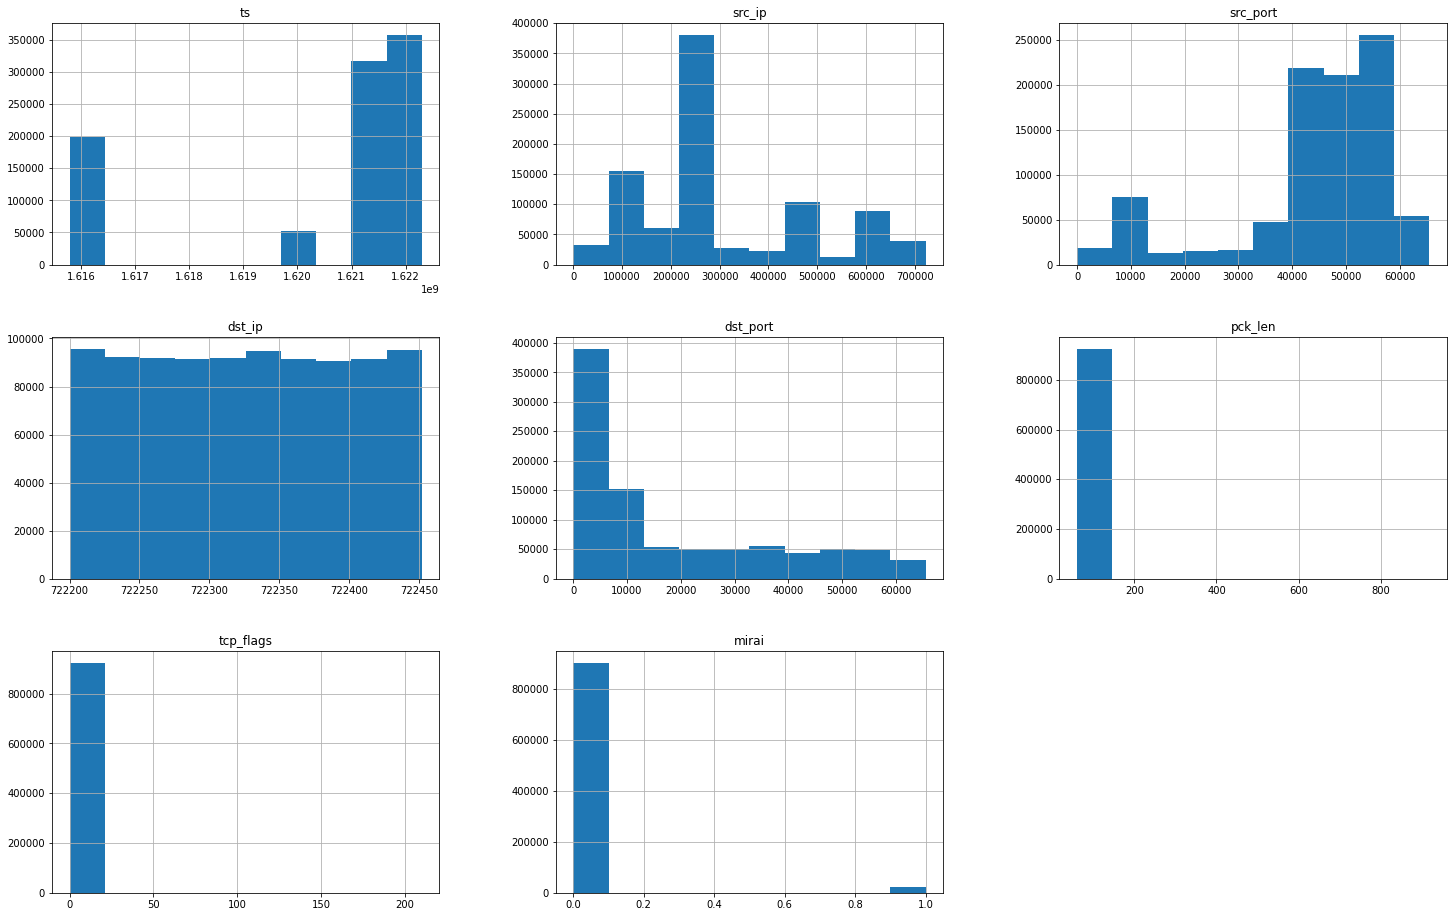

In [ ]:
dark.hist(column=names, figsize=(25,16))
plt.show()

## Dummy
The column tcp_flags should be a list of the following flags:
*   NS: ECN-nonce - concealment protection
*   CWR: Congestion window reduced (CWR) flag is set by the sending host to indicate that it received a TCP segment with the ECE flag set and had responded in congestion control mechanism.
*   ECE: ECN-Echo has a dual role, depending on the value of the SYN flag. It indicates:
If the SYN flag is set (1), that the TCP peer is ECN capable.
If the SYN flag is clear (0), that a packet with Congestion Experienced flag set (ECN=11) in the IP header was received during normal transmission.[b] This serves as an indication of network congestion (or impending congestion) to the TCP sender.
*   URG: Indicates that the Urgent pointer field is significant
*   ACK: Indicates that the Acknowledgment field is significant. All packets after the initial SYN packet sent by the client should have this flag set.
*   PSH: Push function. Asks to push the buffered data to the receiving application.
*   RST: Reset the connection
*   SYN: Synchronize sequence numbers. Only the first packet sent from each end should have this flag set. Some other flags and fields change meaning based on this flag, and some are only valid when it is set, and others when it is clear.
*   FIN: Last packet from sender

In [ ]:
tcp_values = dict(dark['tcp_flags'].value_counts().sort_index(ascending=True))
for k in tcp_values:
  print(format(int(k), "9b"), " ", tcp_values[k])

dark2 = pandas.get_dummies(dark, columns=['tcp_flags'], drop_first=False)
list(set(dark2)-set(dark))

        0   1
       10   917679
      100   780
    10000   328
    10001   1
    10010   5575
    10100   316
    11000   16
   111111   1
  1010010   85
 11000010   1139
 11010010   33


['tcp_flags_2.0',
 'tcp_flags_17.0',
 'tcp_flags_210.0',
 'tcp_flags_18.0',
 'tcp_flags_194.0',
 'tcp_flags_4.0',
 'tcp_flags_20.0',
 'tcp_flags_82.0',
 'tcp_flags_0.0',
 'tcp_flags_16.0',
 'tcp_flags_63.0',
 'tcp_flags_24.0']

The NS bit is always 0. I won't discard invalid flags cobinations
Let's make tcp_flags a list of dummies

In [ ]:
fin = dark.tcp_flags.apply(lambda x: int(x) & (1 << 0) > 0)
syn = dark.tcp_flags.apply(lambda x: int(x) & (1 << 1) > 0)
rst = dark.tcp_flags.apply(lambda x: int(x) & (1 << 2) > 0)
psh = dark.tcp_flags.apply(lambda x: int(x) & (1 << 3) > 0)
ack = dark.tcp_flags.apply(lambda x: int(x) & (1 << 4) > 0)
urg = dark.tcp_flags.apply(lambda x: int(x) & (1 << 5) > 0)
ece = dark.tcp_flags.apply(lambda x: int(x) & (1 << 6) > 0)
cwr = dark.tcp_flags.apply(lambda x: int(x) & (1 << 7) > 0)
dark.pop('tcp_flags')
dark['FIN'] = fin
dark['SYN'] = syn
dark['RST'] = rst
dark['PSH'] = psh
dark['ACK'] = ack
dark['URG'] = urg
dark['ECE'] = ece
dark['CWR'] = cwr
names=['ts','src_ip','src_port','dst_ip','dst_port','pck_len','mirai','FIN','SYN','RST','PSH','ACK','URG','ECE','CWR']
dark

,ts,src_ip,src_port,dst_ip,dst_port,pck_len,mirai,FIN,SYN,RST,PSH,ACK,URG,ECE,CWR
0,1.622299e+09,486158,26264.0,722278,47933.0,60,0.0,False,True,False,False,False,False,False,False
1,1.622299e+09,242994,45785.0,722286,11949.0,60,0.0,False,True,False,False,False,False,False,False
2,1.622299e+09,242994,45785.0,722314,11758.0,60,0.0,False,True,False,False,False,False,False,False
3,1.622299e+09,242996,46004.0,722291,24680.0,60,0.0,False,True,False,False,False,False,False,False
4,1.622299e+09,242999,46096.0,722294,44049.0,60,0.0,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.621353e+09,242993,42493.0,722412,73.0,60,0.0,False,True,False,False,False,False,False,False
999996,1.621353e+09,242998,42415.0,722209,32818.0,60,0.0,False,True,False,False,False,False,False,False
999997,1.621353e+09,242996,42391.0,722378,19960.0,60,0.0,False,True,False,False,False,False,False,False
999998,1.621353e+09,589938,54368.0,722243,50070.0,60,0.0,False,True,False,False,False,False,False,False


##Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaleCols = ['ts',	'src_ip',	'src_port',	'dst_ip',	'dst_port',	'pck_len'	]
darkScaledPart = StandardScaler().fit_transform(dark[scaleCols])
dark[scaleCols] = darkScaledPart
dark.mirai = dark.mirai.astype(np.int8)
dark.FIN = dark.FIN.astype(np.int8)
dark.SYN = dark.SYN.astype(np.int8)
dark.RST = dark.RST.astype(np.int8)
dark.PSH = dark.PSH.astype(np.int8)
dark.ACK = dark.ACK.astype(np.int8)
dark.URG = dark.URG.astype(np.int8)
dark.ECE = dark.ECE.astype(np.int8)
dark.CWR = dark.CWR.astype(np.int8)
dark.sort_values(by=['ts'], inplace=True)
dark.reset_index(inplace=True)
dark.pop('index')
dark

,ts,src_ip,src_port,dst_ip,dst_port,pck_len,mirai,FIN,SYN,RST,PSH,ACK,URG,ECE,CWR
0,-1.929549,-0.305615,0.408050,-1.364813,-0.325040,-0.372593,0,0,1,0,0,0,0,0,0
1,-1.929549,-0.305615,0.408050,1.220952,-0.325040,-0.372593,0,0,1,0,0,0,0,0,0
2,-1.929549,-0.091337,-0.179027,-1.282725,1.696577,-0.372593,0,0,1,0,0,0,0,0,0
3,-1.929549,0.854345,0.852044,-0.749155,-0.532383,-0.372593,0,0,1,0,0,0,0,0,0
4,-1.929549,-0.242452,0.362693,-0.543935,-0.776717,-0.372593,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925949,0.780368,-0.322209,0.121754,-0.160859,1.010687,-0.372593,0,0,1,0,0,0,0,0,0
925950,0.780368,2.094923,-0.070224,-0.338716,-0.790805,-0.372593,0,0,1,0,0,0,0,0,0
925951,0.780368,-1.486937,-1.507404,-0.530254,-0.952807,-0.372593,1,0,1,0,0,0,0,0,0
925952,0.780368,-0.322237,0.103992,-1.446901,-0.691620,-0.372593,0,0,1,0,0,0,0,0,0


##PCA

Again plots

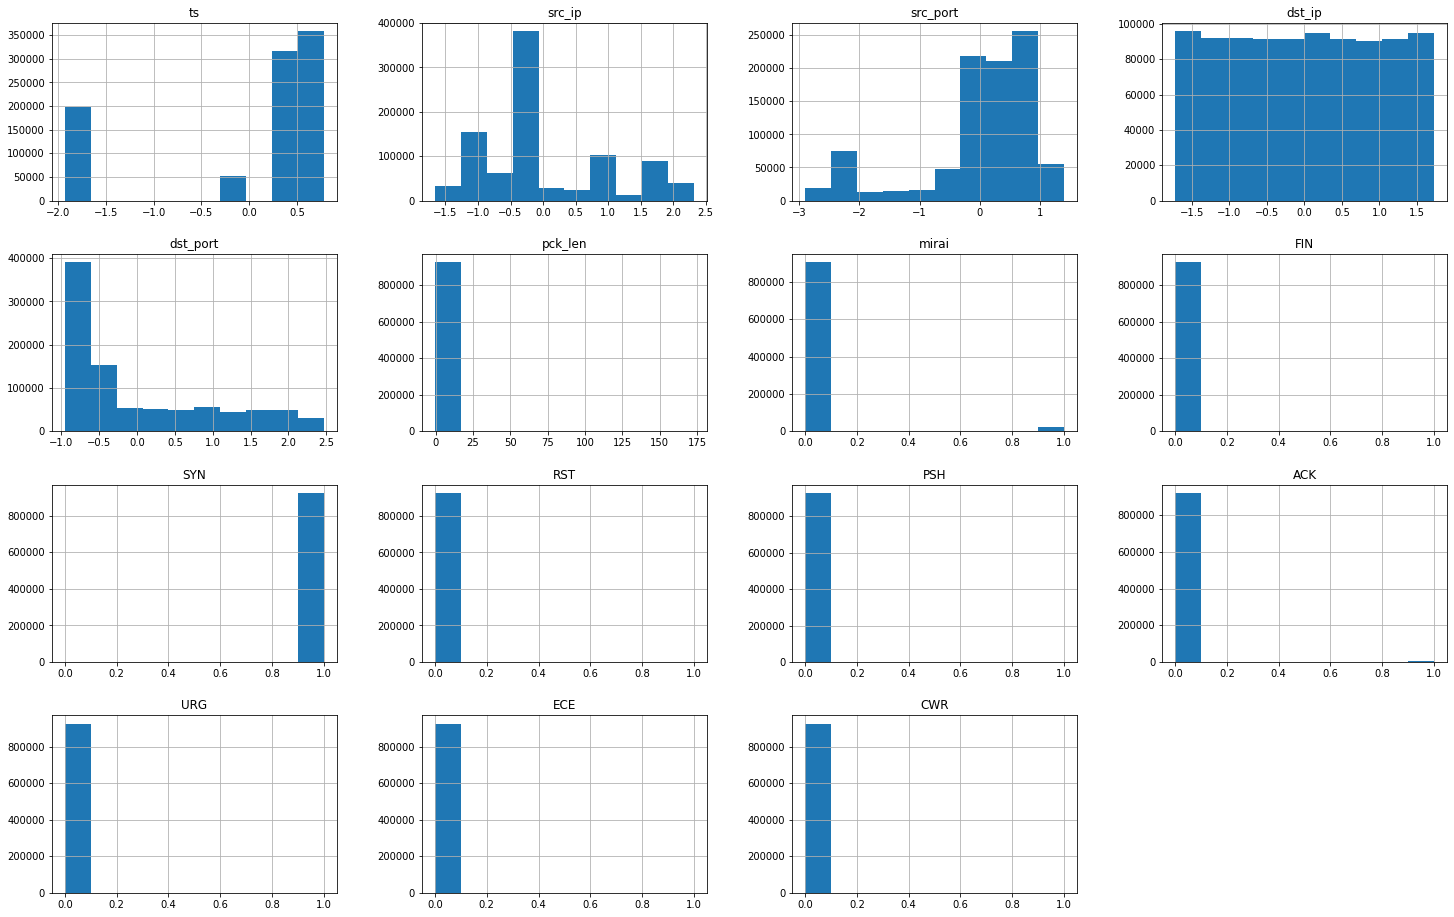

In [ ]:
dark.hist(column=names, figsize=(25,16))
plt.show()

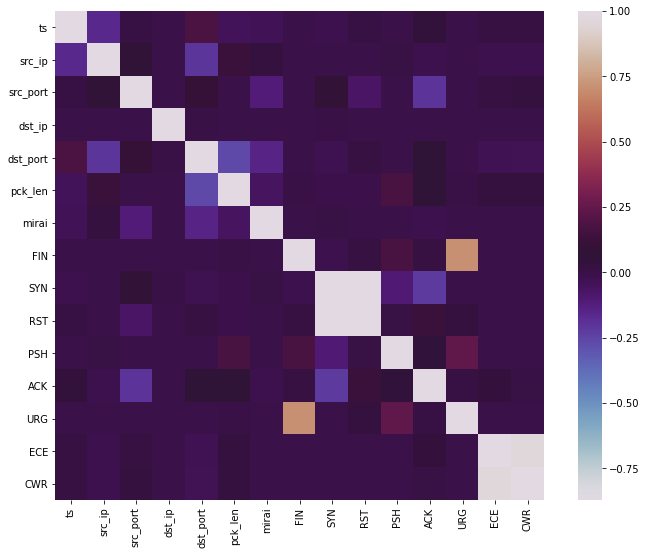

In [ ]:
CORR = dark.corr()
fig = plt.figure(figsize=(12,9))
seaborn.heatmap(CORR, square=True, cmap=plt.cm.twilight)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pc = pca.fit_transform(dark)
pca.explained_variance_ratio_

array([2.48564354e-01, 1.75799434e-01, 1.65842678e-01, 1.60332698e-01,
       1.32246473e-01, 1.11667856e-01, 3.59485096e-03, 1.08529629e-03,
       4.25035843e-04, 4.02970796e-04, 2.76350365e-05, 7.36009727e-06,
       2.85049761e-06, 4.41943871e-07, 6.63542517e-08])

Column 15 (CWR) is basically useless, as also seen in the correlation matrix graph.

In [ ]:
colsToRemove = 9
pcaRed = PCA(n_components=len(dark.columns)-colsToRemove, svd_solver = 'full')
pcRed = pcaRed.fit_transform(dark)
print(f"Variance without {colsToRemove} ({len(dark.columns)-colsToRemove} cols instead of {len(dark.columns)}) column: {round(np.sum(pcaRed.explained_variance_ratio_)*100,20)}%")

Variance without 9 (6 cols instead of 15) column: 99.44534921749907%


But in the end I prefer just kicking column 15 mantaining each column's meaning (albeit mediated by Scaler)

In [ ]:
if 'CWR' in dark.columns:
  dark.pop('CWR')

Finally, save the processed datased

In [ ]:
bin = True
if not bin:
  dark.to_csv("dark3.csv", index=False, header=False)
else:
  print(dark.info())
  dark.to_feather('/content/drive/MyDrive/Darknet/dark.f')
  print(dark.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925954 entries, 0 to 925953
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        925954 non-null  float64
 1   src_ip    925954 non-null  float64
 2   src_port  925954 non-null  float64
 3   dst_ip    925954 non-null  float64
 4   dst_port  925954 non-null  float64
 5   pck_len   925954 non-null  float64
 6   mirai     925954 non-null  int8   
 7   FIN       925954 non-null  int8   
 8   SYN       925954 non-null  int8   
 9   RST       925954 non-null  int8   
 10  PSH       925954 non-null  int8   
 11  ACK       925954 non-null  int8   
 12  URG       925954 non-null  int8   
 13  ECE       925954 non-null  int8   
dtypes: float64(6), int8(8)
memory usage: 49.5 MB
None
                 ts        src_ip  ...            URG            ECE
count  9.259540e+05  9.259540e+05  ...  925954.000000  925954.000000
mean   3.200648e-13 -2.784438e-13  ...       0.000001   

# Static Analysis

In this section I will try to group packets by their attributes.
Since all packets in this dataset are considered malicious, the cluster formed shuld be treated as identikit for new packets: their similarity with one of these cluster's packets would suggest similarity in attack scheme, while their being eventually different to all cluster should testify a new kind of attack, or just being non malicious traffic.

Packets in this dataset are caracterized by just low level features, no semantics is included. Thus non malicious packets could easily fit in any of the cluster formed. What I think will work as a decider is the fact that a long series of non malicious packets won't fall repeatedly in any cluster. One could build a two layer network:
*   a clustering layer with the task of replacing low level packet informations with a cluster tag
*   a recurrent network, or a non recurrent one based on well known Transformers-like architectures, trained on classifying timestamp-cluster series

Here we do not have enough computational resources to clusterize. We're working instead with circa 1/4000 of the samples, and reducing to three dimensions with PCA to present plots (left graph: all points, right graph: focus on the main cluster).

In [ ]:
import numpy as np
import pandas, seaborn, os, csv
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
dark = pandas.read_feather('/content/drive/MyDrive/Darknet/darksample.f')
dark.pop('ts');
darkSS = dark.sample(frac=0.02) # Since we're collapsing to 3 dimension and since cpu and ram limitations, it's needed
# dark = pandas.read_feather('/content/drive/MyDrive/Darknet/dark.f')

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca3 = PCA(n_components=3, svd_solver = 'full')
pc3 = pca3.fit_transform(darkSS)

In [ ]:
def plotPc3(clusterLabels):
  fig = plt.figure(figsize=(25,10))
  ax1 = fig.add_subplot(1, 2, 1, projection='3d')
  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  d = pandas.DataFrame(pc3, columns=['a', 'b', 'c'])
  if type(clusterLabels) == np.ndarray:
    d['cluster'] = clusterLabels
  d = d[d.a<0]
  d = d[d.b<500]
  d = d[d.c<0]
  if type(clusterLabels) == np.ndarray:
    ax1.scatter(pc3[:,0], pc3[:,1], pc3[:,2], c=clusterLabels)
    ax2.scatter(d.a, d.b, d.c, c=d.cluster)
  else:
    ax1.scatter(pc3[:,0], pc3[:,1], pc3[:,2])
    ax2.scatter(d.a, d.b, d.c)

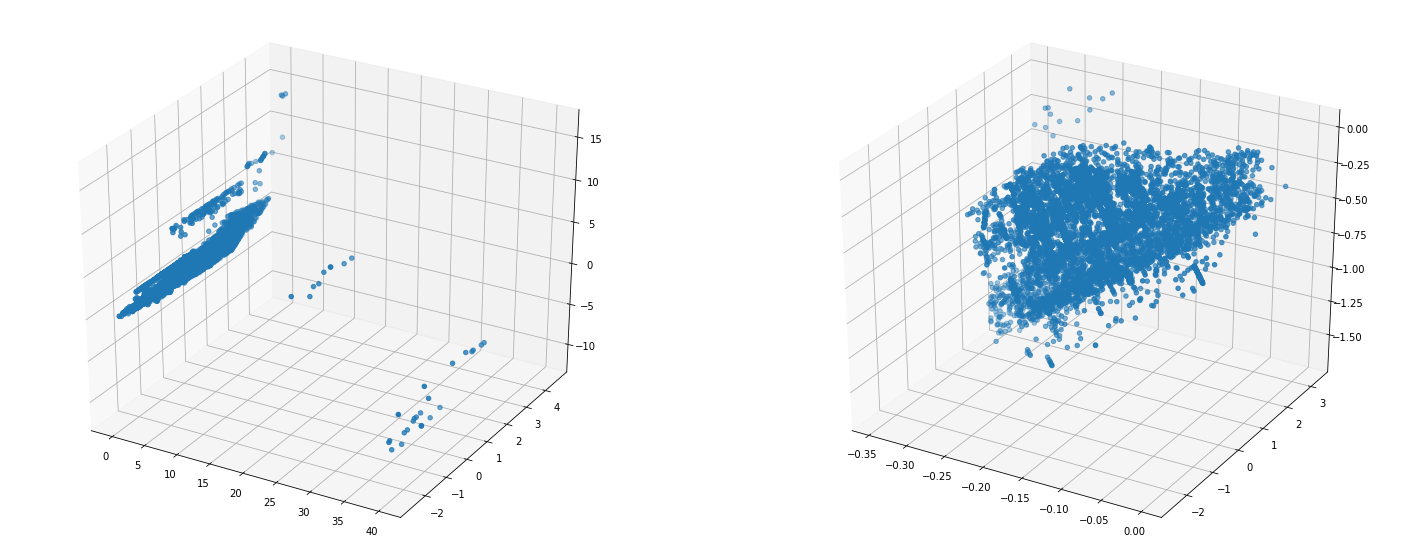

In [ ]:
plotPc3(False)

## LOF clustering

(array([-1,  1]), array([ 1172, 17347]))
NN: 10, Silhouette: 0.005576244300487936
(array([-1,  1]), array([ 1866, 16653]))
NN: 50, Silhouette: 0.16969499240664546
(array([-1,  1]), array([ 2414, 16105]))
NN: 150, Silhouette: 0.1540997089850631
(array([-1,  1]), array([  767, 17752]))
NN: 300, Silhouette: 0.6109204150576107
(array([-1,  1]), array([  844, 17675]))
NN: 1000, Silhouette: 0.6306747974035398
(array([-1,  1]), array([ 2125, 16394]))
NN: 5000, Silhouette: 0.5220601971985418


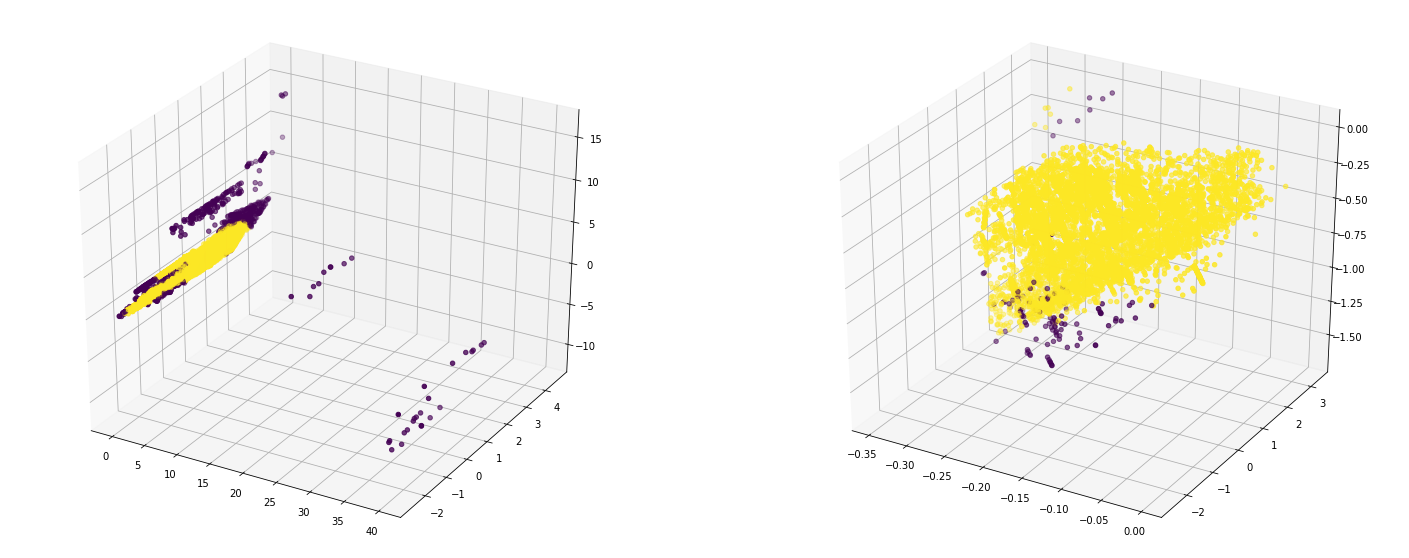

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

bestSihl = 0
bestCl = None
for nn in [10, 50, 150, 300, 1000, 5000]:
  lof = LocalOutlierFactor(n_neighbors=nn)
  clusters = lof.fit_predict(pc3)
  print(np.unique(clusters, return_counts=True))
  sihl = silhouette_score(pc3, clusters, metric = 'euclidean')
  print(f"NN: {nn}, Silhouette: {sihl}")
  if sihl > bestSihl:
    bestSihl = sihl
    bestCl = clusters
plotPc3(bestCl)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=500, n_jobs=6)
clusters = lof.fit_predict(darkSS)
print(np.unique(clusters, return_counts=True))
silhouette_score(darkSS, clusters, metric = 'euclidean')

(array([-1,  1]), array([ 1204, 17315]))


0.5294285399406051

## K-Means clustering

(array([0, 1], dtype=int32), array([18486,    33]))
N°Cluster: 2, Silhouette: 0.9460676120576826
(array([0, 1, 2], dtype=int32), array([12047,    33,  6439]))
N°Cluster: 3, Silhouette: 0.4291523826147652
(array([0, 1, 2, 3, 4], dtype=int32), array([10071,    33,  5980,   148,  2287]))
N°Cluster: 5, Silhouette: 0.48268496608189426


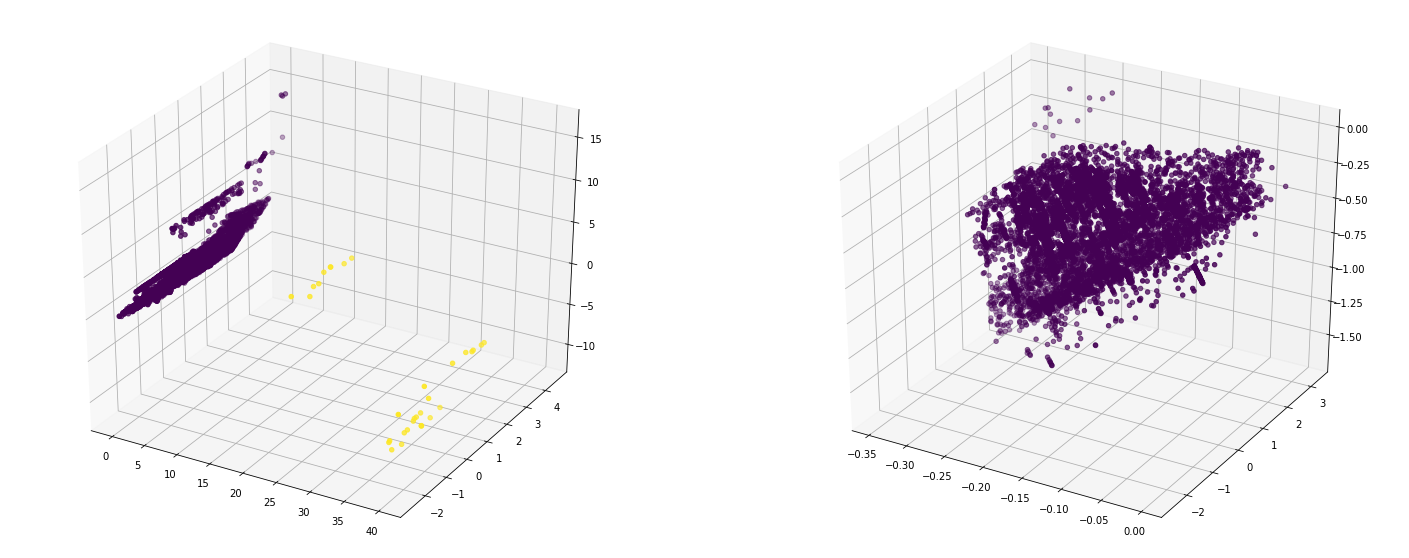

In [ ]:
from sklearn.cluster import KMeans

bestSihl = 0
bestCl = None
for nc in [2, 3, 5]:
  kmeans = KMeans(n_clusters=nc, n_init=100, max_iter=1000, tol=0.0001)
  clusters = kmeans.fit_predict(pc3)
  print(np.unique(clusters, return_counts=True))
  sihl = silhouette_score(pc3, clusters, metric = 'euclidean')
  print(f"N°Cluster: {nc}, Silhouette: {sihl}")
  if sihl > bestSihl:
    bestSihl = sihl
    bestCl = clusters
plotPc3(bestCl)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=1000, tol=0.0001, n_jobs=6)
clusters = kmeans.fit_predict(darkSS)
print(np.unique(clusters, return_counts=True))
silhouette_score(darkSS, clusters, metric = 'euclidean')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([5924,  119,   24, 4664,  429, 2059, 1872,   29, 3390,    9]))


0.32009140561121224

## DBSCAN clustering

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([ 1160, 16516,   298,   283,    93,    18,    43,    11,    10,
          23,    10,    16,    10,    11,    10,     7]))
Eps: 0.1, Silhouette: -0.25307621954760207
(array([-1,  0,  1,  2]), array([  618, 17848,    35,    18]))
Eps: 0.3, Silhouette: 0.3429004724493548
(array([-1,  0]), array([  181, 18338]))
Eps: 1, Silhouette: 0.8704263410662136
(array([-1,  0]), array([  181, 18338]))
Eps: 3, Silhouette: 0.8704263410662136
(array([-1,  0]), array([   33, 18486]))
Eps: 10, Silhouette: 0.9460676120576826
(array([-1,  0]), array([   24, 18495]))
Eps: 20, Silhouette: 0.9521840423615909


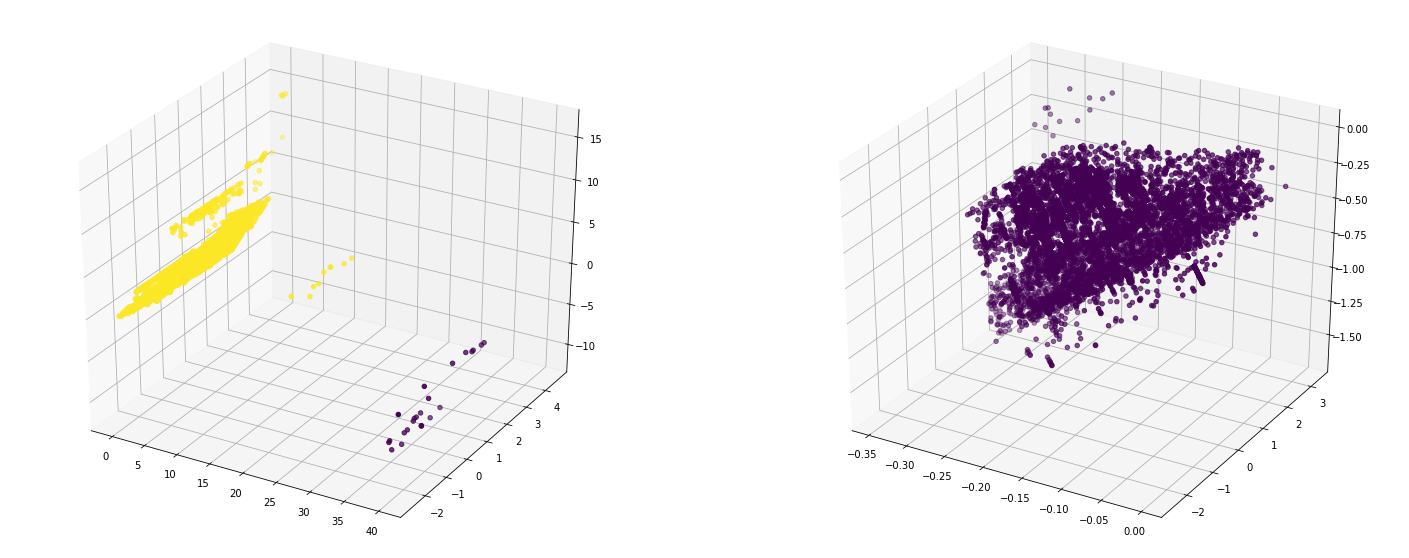

In [ ]:
from sklearn.cluster import DBSCAN

bestSihl = 0
bestCl = None
for e in [0.1, 0.3, 1, 3, 10, 20]:
  dbscan = DBSCAN(eps=e, min_samples=100*e)
  clusters = dbscan.fit_predict(pc3)
  print(np.unique(clusters, return_counts=True))
  sihl = silhouette_score(pc3, clusters, metric = 'euclidean')
  print(f"Eps: {e}, Silhouette: {sihl}")
  if sihl > bestSihl:
    bestSihl = sihl
    bestCl = clusters
plotPc3(bestCl)

In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=10, min_samples=50)
clusters = dbscan.fit_predict(darkSS)
print(np.unique(clusters, return_counts=True))
silhouette_score(darkSS, clusters, metric = 'euclidean')

(array([-1,  0,  1]), array([   62, 18338,   119]))


0.7581547978750813

## One class SVM

(array([-1,  1]), array([  186, 18333]))
μ: 0.01, γ: 0.01, Silhouette: 0.8322065489881669
(array([-1,  1]), array([  186, 18333]))
μ: 0.01, γ: 0.1, Silhouette: 0.8283017377785913
(array([-1,  1]), array([  185, 18334]))
μ: 0.01, γ: 0.5, Silhouette: 0.8201121140114267
(array([-1,  1]), array([  189, 18330]))
μ: 0.01, γ: 1, Silhouette: 0.8121716122815663
(array([-1,  1]), array([  216, 18303]))
μ: 0.01, γ: 5, Silhouette: 0.7555791880640631
(array([-1,  1]), array([  302, 18217]))
μ: 0.01, γ: 10, Silhouette: 0.6741641382126644
(array([-1,  1]), array([ 1851, 16668]))
μ: 0.1, γ: 0.01, Silhouette: 0.5049007711621973
(array([-1,  1]), array([ 1851, 16668]))
μ: 0.1, γ: 0.1, Silhouette: 0.5050310768859056
(array([-1,  1]), array([ 1856, 16663]))
μ: 0.1, γ: 0.5, Silhouette: 0.4829975408350592
(array([-1,  1]), array([ 1851, 16668]))
μ: 0.1, γ: 1, Silhouette: 0.47363745736526
(array([-1,  1]), array([ 1855, 16664]))
μ: 0.1, γ: 5, Silhouette: 0.46412263592885367
(array([-1,  1]), array([ 1858, 16

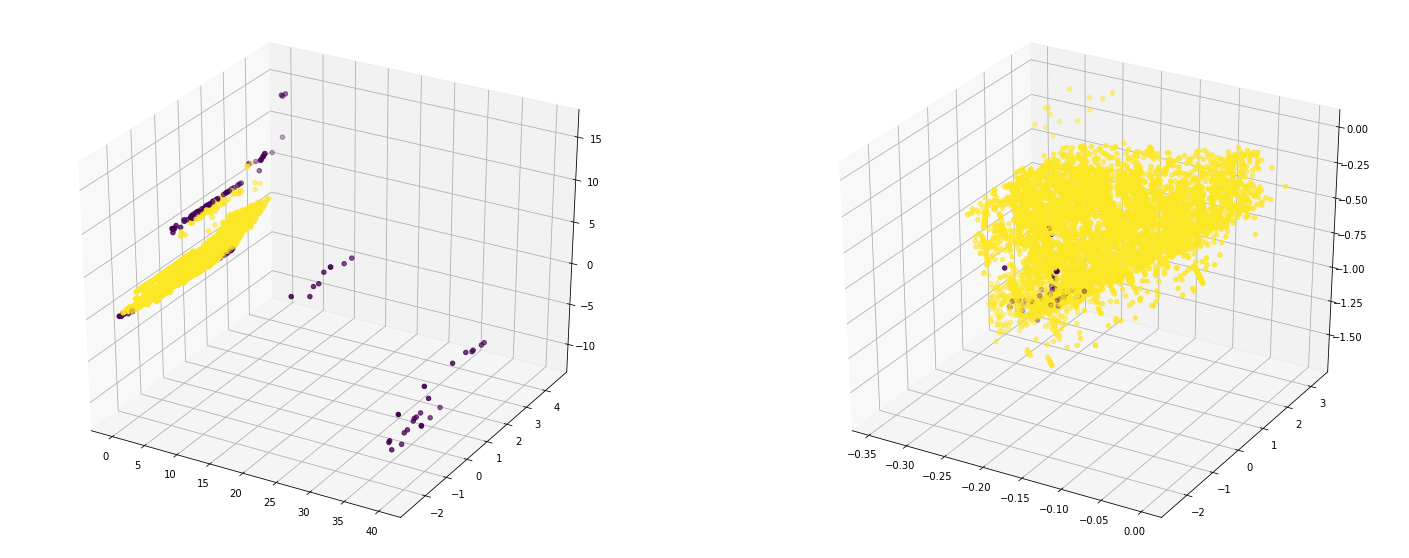

In [ ]:
from sklearn.svm import OneClassSVM

bestSihl = 0
bestCl = None
for m in [1e-2, 1e-1, .5, .9]:
  for g in [1e-2, .1, .5, 1, 5, 10]:
    osvm = OneClassSVM(nu=m, kernel="rbf", gamma=g) # nu between 0 and 1
    clusters = osvm.fit_predict(pc3)
    print(np.unique(clusters, return_counts=True))
    sihl = silhouette_score(pc3, clusters, metric = 'euclidean')
    print(f"μ: {m}, γ: {g}, Silhouette: {sihl}")
    if sihl > bestSihl:
      bestSihl = sihl
      bestCl = clusters
plotPc3(bestCl)

In [ ]:
from sklearn.svm import OneClassSVM
osvm = OneClassSVM(nu=.01, kernel="rbf", gamma=.1)
clusters = osvm.fit_predict(darkSS)
print(np.unique(clusters, return_counts=True))
silhouette_score(darkSS, clusters, metric = 'euclidean')

(array([-1,  1]), array([  181, 18338]))


0.7743978590825584

# Dynamic Analysis

## LSTM
In this section I will try to capture an attacker (identified by its ip)'s behaviour through a LSTM network learning packets coming from it

In [1]:
import numpy as np
import pandas, os, csv

dark = pandas.read_feather('/content/drive/MyDrive/Darknet/darksample.f')
dark = dark.head(100000)

The code behind groups packets (previously sorted by timestamp) by sender in sequences of variable length forming the training and test set.

The parameter SEQLEN represents the longest packet sequence inputable to the LSTM net: secquences longer than that will be split in subsequent training points and treated as different attacks.

Sequences shorter than SEQLEN will be padded with zeros because the NN expects a tensor as an input, not a flexible-sized list.

NOTE: I chose to append dark.iloc[i,3:].to_numpy() instead of dark.iloc[i].to_numpy() (that means excluding timestamp, source ip and port) because it shouldn't matter where the attack is coming from. Filtering attacks by source is more a firewall'effort.

In [2]:
SEQLEN = 50
ISIZE = 11
seqWorkOn = []
sequences = []
# ip seq age
for i in range(len(dark)):
  yetPresentSequence = False
  ip = dark.src_ip[i]
  for s in seqWorkOn:
    if ip == s[0]: #and dark.src_port[i] == s[1] # if one wants to identify attackers also by port used
      yetPresentSequence = True
      s[1].append(dark.iloc[i,3:].to_numpy())
      s[2] = s[2]+1
      if s[2]==SEQLEN:
        sequences.append(s)
        seqWorkOn.remove(s)
  if not yetPresentSequence:
    seqWorkOn.append([dark.src_ip[i], [dark.iloc[i,3:].to_numpy()], 0])

In [3]:
seqCutted = []
for s in seqWorkOn:
  if s[2] > SEQLEN/3: seqCutted.append(s)

train = np.zeros((len(sequences)+len(seqCutted), SEQLEN, ISIZE))
test = np.zeros((len(sequences)+len(seqCutted), ISIZE))
for i in range(0, len(sequences)):
  train[i,:,:] = sequences[i][1][:-1]
  test[i,:] = sequences[i][1][SEQLEN]

startLen = len(sequences)
for i in range(0, len(seqCutted)):
  seqlen = len(seqCutted[i][1])
  train[i+startLen,0:seqlen-1,:] = seqCutted[i][1][:-1]
  test[i+startLen,:] = seqCutted[i][1][seqlen-1]

The following code builds and trains a multi level LSTM + dense network at predicting packet flow

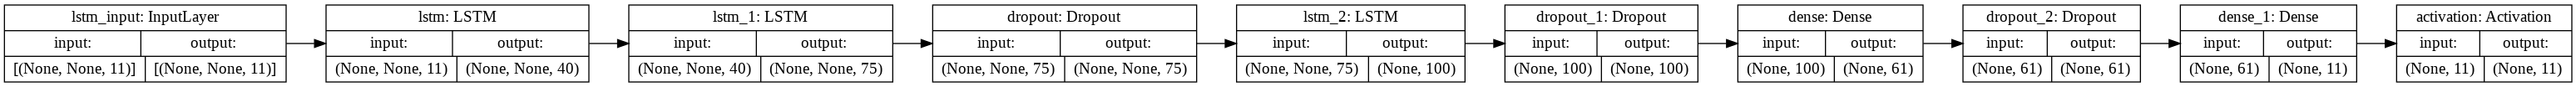

In [4]:
from keras.models import Sequential
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.utils.vis_utils import plot_model

model = Sequential()
model.add(LSTM(input_shape=(None, ISIZE), units=40, return_sequences=True))
model.add(LSTM(units=round(SEQLEN*1.5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=SEQLEN*2, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=SEQLEN+ISIZE))
model.add(Dropout(0.3))
model.add(Dense(units=ISIZE))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

plot_model(model, rankdir="LR", expand_nested=True, show_shapes=True)

In [5]:
from keras.callbacks import EarlyStopping
history = model.fit(train, test,
                    batch_size=20, epochs=20, workers=6,
                    validation_split=.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
82/82 [==============================] - 23s 191ms/step - loss: 0.1499 - val_loss: 0.2098
Epoch 2/20
82/82 [==============================] - 15s 182ms/step - loss: 0.1214 - val_loss: 0.2007
Epoch 3/20
82/82 [==============================] - 15s 183ms/step - loss: 0.1181 - val_loss: 0.1885
Epoch 4/20
82/82 [==============================] - 15s 184ms/step - loss: 0.1152 - val_loss: 0.1921
Epoch 5/20
82/82 [==============================] - 15s 184ms/step - loss: 0.1137 - val_loss: 0.1902
Epoch 6/20
82/82 [==============================] - 15s 185ms/step - loss: 0.1118 - val_loss: 0.1648
Epoch 7/20
82/82 [==============================] - 15s 180ms/step - loss: 0.1100 - val_loss: 0.1266
Epoch 8/20
82/82 [==============================] - 15s 183ms/step - loss: 0.1081 - val_loss: 0.1290
Epoch 9/20
82/82 [==============================] - 15s 185ms/step - loss: 0.1086 - val_loss: 0.1177
Epoch 10/20
82/82 [==============================] - 15s 185ms/step - loss: 0.1071 - val_lo

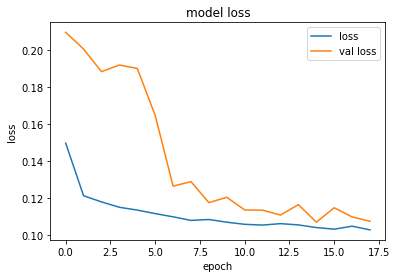

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss", "val loss"])
plt.show()

In [10]:
import random
example = random.randint(0, len(train)-1)
ask = train[example:example+1]
ans = test[example]
p = model.predict(ask)[0]

print(f"MSE: {np.square(np.subtract(ans,p)).mean()}")
view = pandas.DataFrame(index = ['dst_ip','dst_port','pck_len','mirai','FIN','SYN','RST','PSH','ACK','URG','ECE'])
view['Real'] = ans
view['Predicted'] = p
view['Error'] = abs(p-ans)
view

MSE: 0.008259777782613453


,Real,Predicted,Error
dst_ip,0.235899,-0.039154,0.275053
dst_port,1.339806,1.225879,0.113927
pck_len,-0.372593,-0.348357,0.024236
mirai,0.000000,0.020613,0.020613
FIN,0.000000,-0.004212,0.004212
SYN,1.000000,0.965870,0.034130
RST,0.000000,0.003632,0.003632
PSH,0.000000,0.003796,0.003796
ACK,0.000000,0.001109,0.001109
URG,0.000000,-0.000562,0.000562


Results on 5 mln of processed dataset rows (50x the ones here) are (note that the heaviest job is building the training set):


```
Epoch 1/20
4799/4799 [==============================] - 1027s 213ms/step - loss: 0.1039
Epoch 2/20
4799/4799 [==============================] - 740s 154ms/step - loss: 0.0977
Epoch 3/20
4799/4799 [==============================] - 716s 149ms/step - loss: 0.0962
Epoch 4/20
4799/4799 [==============================] - 740s 154ms/step - loss: 0.0957
Epoch 5/20
4799/4799 [==============================] - 737s 154ms/step - loss: 0.0955
Epoch 6/20
4799/4799 [==============================] - 734s 153ms/step - loss: 0.0944
Epoch 7/20
4799/4799 [==============================] - 749s 156ms/step - loss: 0.0953
Epoch 8/20
4799/4799 [==============================] - 747s 156ms/step - loss: 0.0945
Epoch 9/20
4799/4799 [==============================] - 732s 153ms/step - loss: 0.0960
Epoch 10/20
4799/4799 [==============================] - 748s 156ms/step - loss: 0.0937
Epoch 11/20
4799/4799 [==============================] - 601s 125ms/step - loss: 0.0936
Epoch 12/20
4799/4799 [==============================] - 547s 114ms/step - loss: 0.0940
Epoch 13/20
4799/4799 [==============================] - 546s 114ms/step - loss: 0.0930
Epoch 14/20
4799/4799 [==============================] - 547s 114ms/step - loss: 0.0924
Epoch 15/20
4799/4799 [==============================] - 549s 114ms/step - loss: 0.0930
Epoch 16/20
4799/4799 [==============================] - 548s 114ms/step - loss: 0.0923
Epoch 17/20
4799/4799 [==============================] - 548s 114ms/step - loss: 0.0918
Epoch 18/20
4799/4799 [==============================] - 546s 114ms/step - loss: 0.0905
Epoch 19/20
4799/4799 [==============================] - 547s 114ms/step - loss: 0.0915
Epoch 20/20
4799/4799 [==============================] - 546s 114ms/step - loss: 0.0928
```

